In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.pipelines.texgen_pipeline import TexGenLogic
import torch

from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texgen_pipeline import TexGenPipeline
from diffusers.schedulers import DDIMScheduler

In [2]:
device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(TexGenPipeline, sd_repo, controlnet_repo, DDIMScheduler)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
texgen = TexGenLogic(pipe, 600, 512, 1.5, 7.5, 1.0, [])

In [111]:
import numpy as np
from text3d2video.util import read_obj_with_uvs
from text3d2video.utilities.camera_placement import (
    cam_view_prompt,
    turntable_extrinsics,
)
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/cat_statue.obj"
device = "cuda"

# read mesh
mesh, verts_uvs, faces_uvs = read_obj_with_uvs(mesh_path, device=device)

n_frames = 8
dist = 5.8

angles = np.linspace(0, 360, n_frames, endpoint=False)
R, T = turntable_extrinsics(dists=dist, angles=angles)
frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
prompt_suffixes = [f", {cam_view_prompt(a, 0)} view" for a in angles]
frame_meshes = mesh.extend(len(frame_cams))

  warnings.warn(f"Mtl file does not exist: {f}")



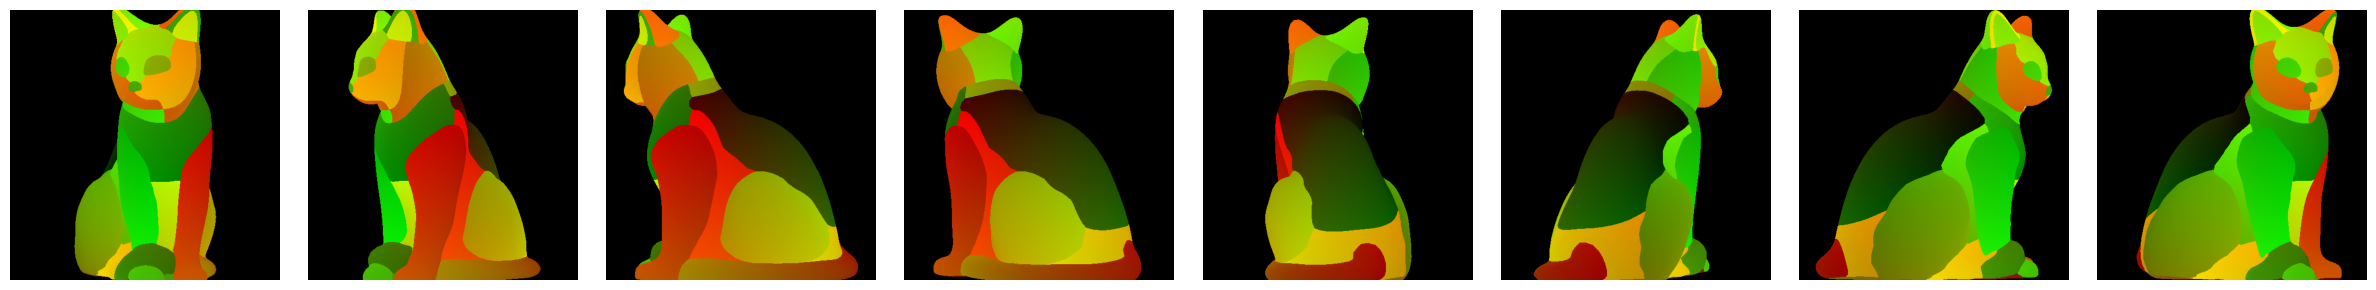

In [129]:
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_ims

uv_renders = render_rgb_uv_map(frame_meshes, frame_cams, verts_uvs, faces_uvs)

display_ims(uv_renders)

In [130]:
projections, fragments = texgen.precompute_projections(
    frame_meshes, frame_cams, verts_uvs, faces_uvs
)

torch.Size([8, 512, 512])


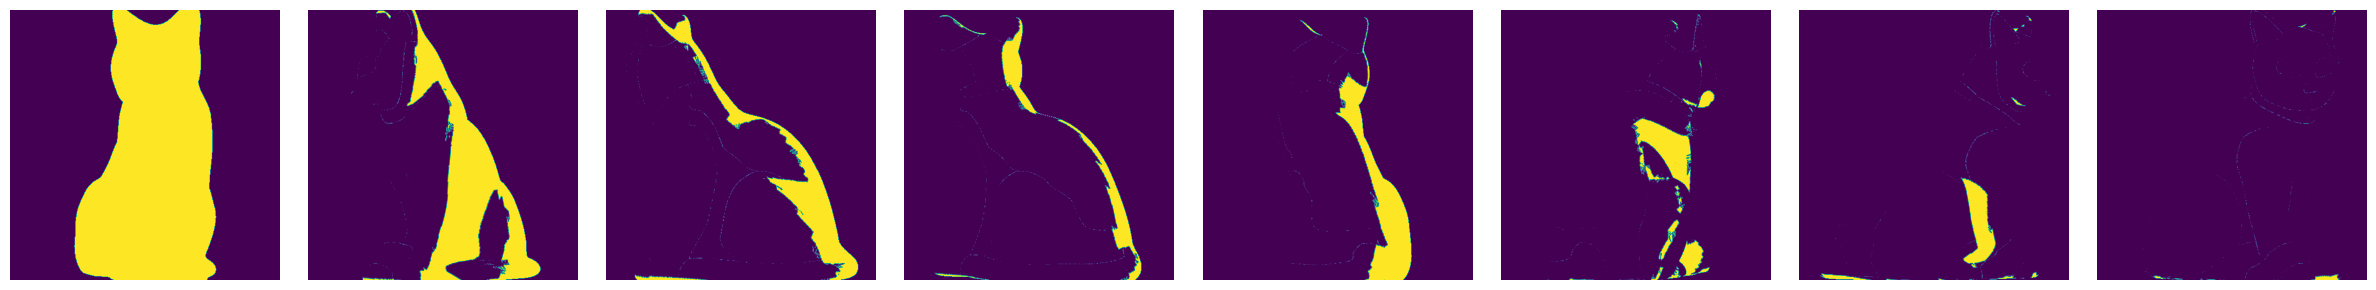

In [131]:
newly_visible_masks = texgen.precompute_newly_visible_masks(
    frame_meshes, fragments, verts_uvs, faces_uvs, projections
)

print(newly_visible_masks.shape)
display_ims(newly_visible_masks.cpu())

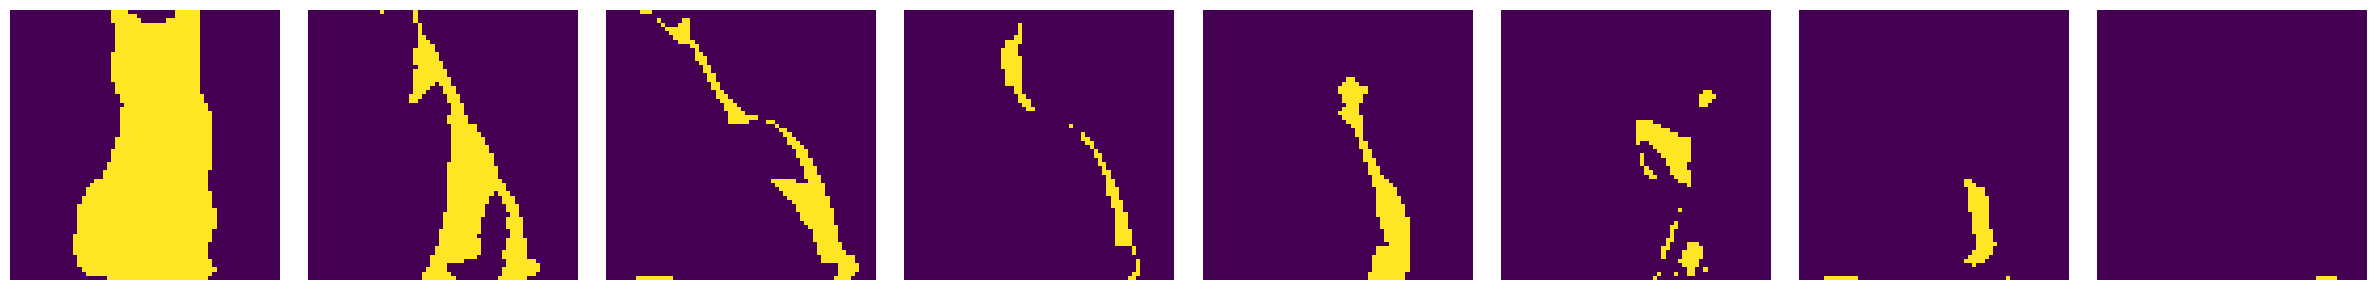

In [125]:
from text3d2video.rendering import downsample_masks

newly_visible_down = downsample_masks(newly_visible_masks, (64, 64))

display_ims(newly_visible_down.cpu())

# Mask Dilation

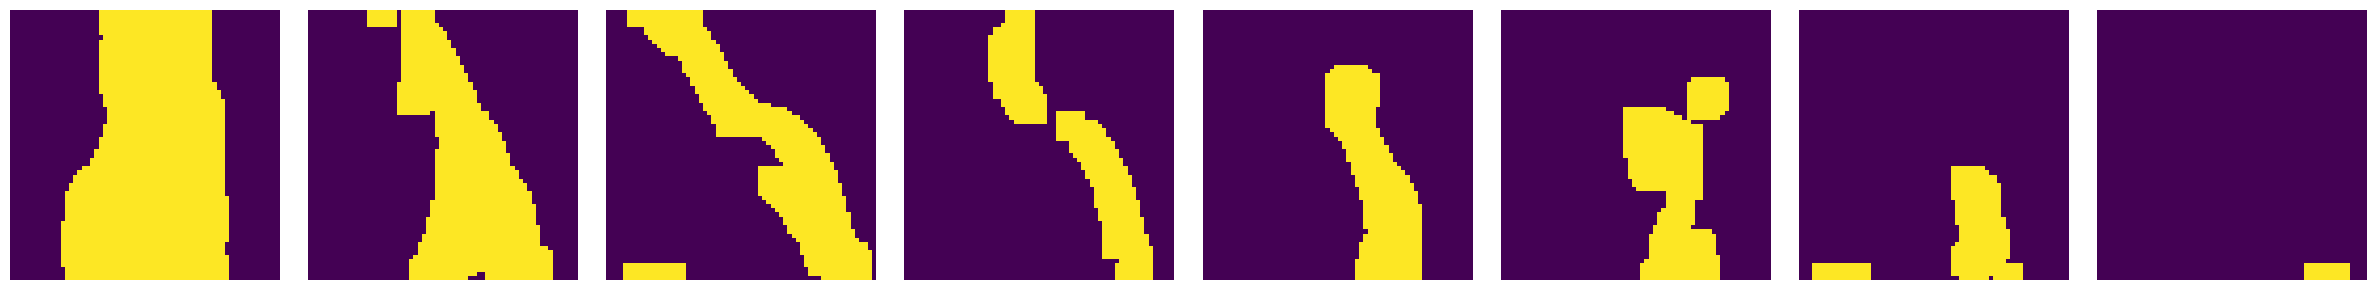

In [126]:
import kornia.morphology as morph

masks = newly_visible_down.float()
kernel_size = 7

kernel = torch.ones(kernel_size, kernel_size)
masks_unsqueezed = masks.unsqueeze(1)
result = morph.dilation(masks_unsqueezed, kernel=kernel)
result = result.squeeze(1)

display_ims(result.cpu())

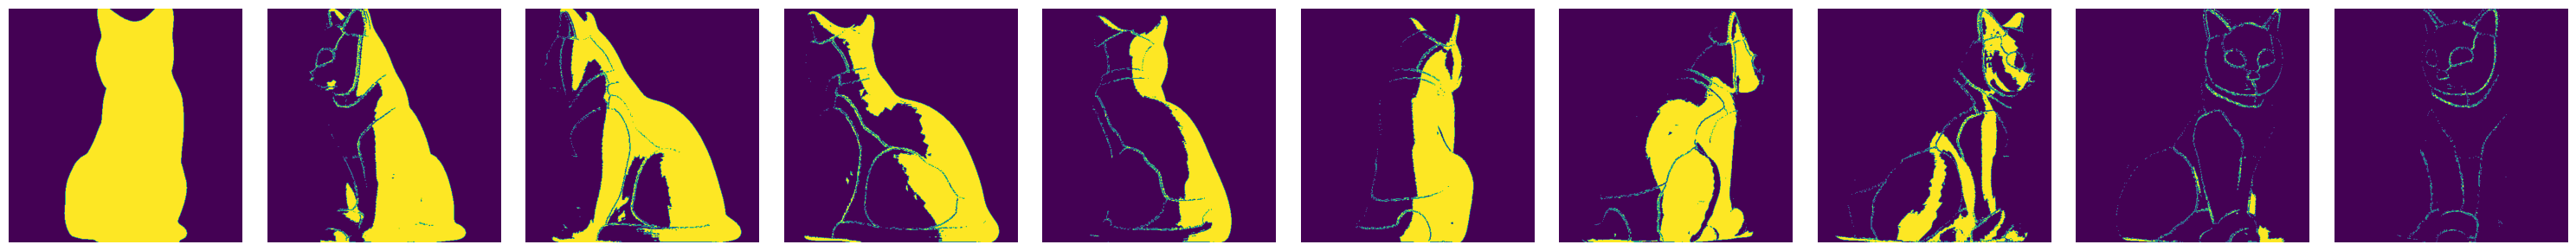

In [83]:
texgen.quality_update_factor = 1.5
update_masks = texgen.precompute_update_masks(
    frame_meshes, fragments, projections, verts_uvs, faces_uvs
)

display_ims(update_masks.cpu())

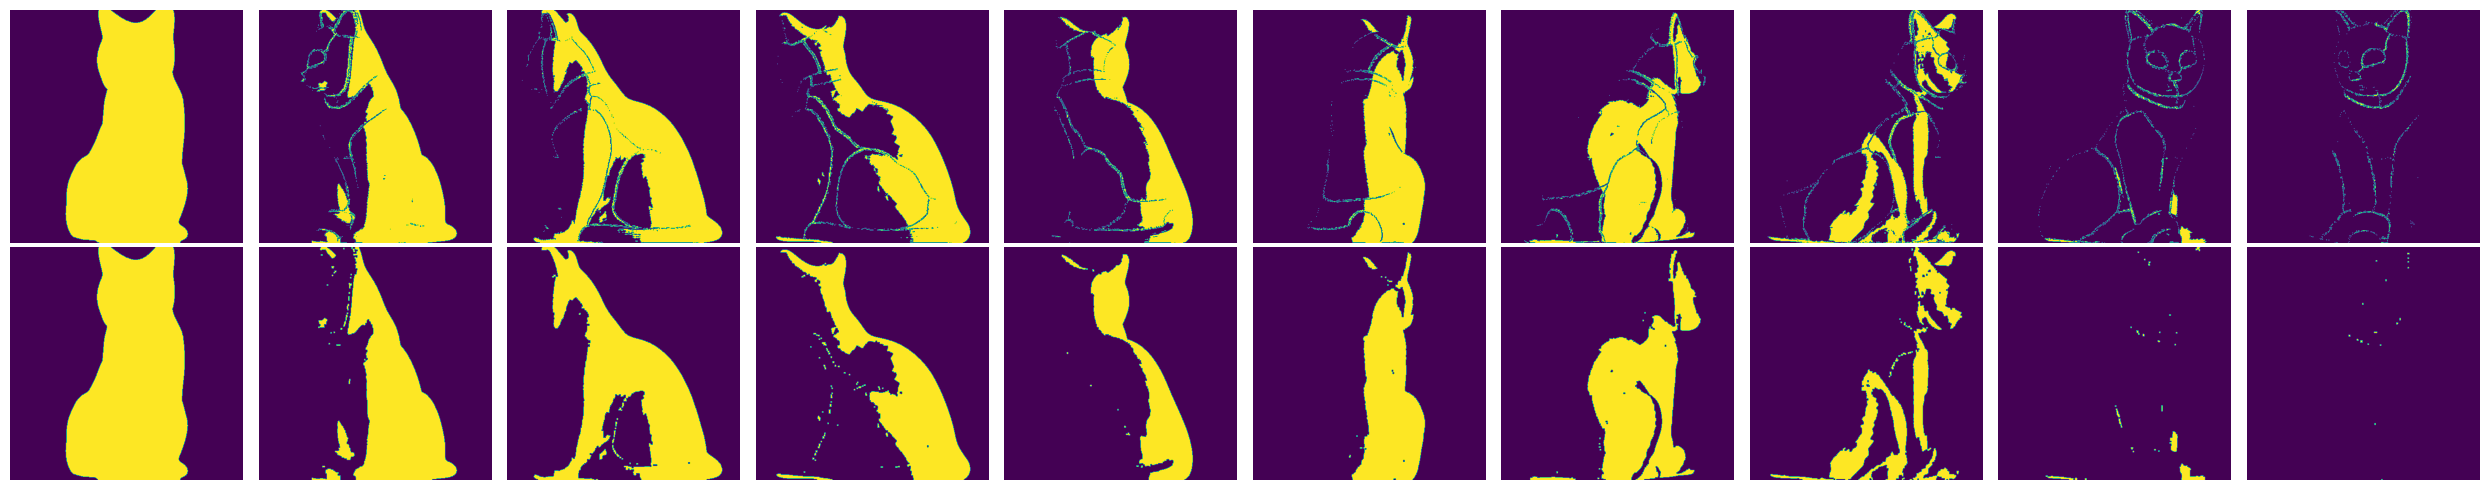

In [84]:
import kornia.morphology as morph

from text3d2video.utilities.ipython_utils import display_ims_grid

kernel_size = 3
kernel = torch.ones(kernel_size, kernel_size)

mask_unsqueezed = update_masks.unsqueeze(1).float()

cleaned = morph.closing(morph.opening(mask_unsqueezed, kernel=kernel), kernel=kernel)[
    :, 0, :, :
]

display_ims_grid([update_masks, cleaned])


# display_ims(
#     [mask, cleaned],
#     titles=["mask", "cleaned"],
# )